# APWP construction from directional data

The site resampling includes directional and age uncertainty and enables a way to propagate uncertainty from the site level to the APWP


In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from vgptools.auxiliar import (get_files_in_directory, spherical2cartesian, 
                               cartesian2spherical, GCD_cartesian, shape)                              
from vgptools.utils_compilation import dfs_vgps_recomputed_poles
from vgptools.utils_APWPs import running_mean_APWP, running_mean_APWP_shape, RM_stats
from vgptools.utils_visualization import  RM_stats, plot_VGPs_and_APWP, plot_APWP_RM_ensemble, quantiles,plot_pole_A95, plot_pole

## Compiles a DataFrame for both, the VGPs and the recomputed poles by study

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'

In [3]:
df_filtered_vgps, df_pole_compilation_by_study = dfs_vgps_recomputed_poles(data_path_VGP, by_study = True)

## Generate a new Dataframe sampling each direction from a Fisher distribution. 

Each entry is now generated sampling from a distribution $\text{Fisher}(\mu, \kappa)$ with $\kappa$ and $\mu$ as concentration and mean parameters. The age of each entry is taken at random from an uniform distribution between the max and min ages. This approach allow us to represent and propagae the uncertainty from the directional space towards the pole space. 

In [4]:
def get_vgps_sampling_direction(df):
    '''
    takes a DF with site information, it draws for each direction a random direction following the
    kappa concentration parameter and mean direction. Then, it calculates from the random direction a given VGP
    In the present formulation we follow a conservative approach for the assignaiton of ages to each direction/VGP, 
    it is taken at random between the min_age and max_age of reported VGPs.
    '''    
    Study, age_bst, decs, incs, slat, slon, indexes = [], [], [], [], [], [], []
    k_mean = df['k'].mean()
    
    for index, row in df.iterrows():        
        # we first generate one random direction from the original entry.
        kappa = k_mean if np.isnan(row.k) else row.k # if we don't have kappa, we take the mean of the reported ones       
        
        directions_temp = ipmag.fishrot(k = kappa, n = 1, dec = row.dec_reverse, inc = row.inc_reverse, di_block = False)
        
        decs.append(directions_temp[0][0])
        incs.append(directions_temp[1][0])
        slat.append(row.slat)
        slon.append(row.slon)
        indexes.append(index)
        
        # make an if statement for normal oor uniform disttributions
        age_bst.append(np.random.randint(np.floor(row.min_age),np.ceil(row.max_age)))
        
        Study.append(row.Study)
        
    dictionary = {
                  'Study': Study,
                  'age': age_bst,
                  'dec': decs,    
                  'inc': incs,
                  'slat': slat,
                  'slon': slon 
                  }    
    new_df = pd.DataFrame(dictionary)        
    new_df['plon'] = new_df.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[0], axis =1)
    new_df['plat'] = new_df.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[1], axis =1)
    
    #set longitude in [-180,180]
    new_df['plon'] = new_df.apply(lambda row: row.plon - 360 if row.plon > 180 else row.plon, axis =1)
    
    new_df.index = indexes

    return new_df

In [5]:
min_age = 0
max_age = 65
window_length = 10
time_step = 5

In [6]:
def running_mean_bootstrapping_direction(df_vgps, plon_label, plat_label, age_label, window_length, time_step, max_age, min_age, n_bst = 100):
    '''
    takes a compilation of vgps (df_vgps). The original direction is taken as PDF to generate a pseudo-Dataset 
    that incorporates the uncertinty in the directional space and time. We apply this method a number $n_bst$ of times
    to  generate $pseudo$-datasets. On each pseudo-dataset we run moving averages as usual.
    '''

    running_means_global = pd.DataFrame(columns=['run','N','k','A95','csd','foliation','lineation','collinearity','coplanarity'])

    for i in range(n_bst):
               
        vgps_sample_ = df_vgps.sample(n = len(df_vgps), replace = True)        
        vgps_sample = get_vgps_sampling_direction(vgps_sample_)
        
#         vgps_sample = get_vgps_sampling_direction(df_vgps)
        
        running_means_tmp = pd.DataFrame()
        running_means_tmp = running_mean_APWP_shape(vgps_sample, plon_label, plat_label, age_label, window_length, time_step, max_age, min_age)
        running_means_tmp['run'] = float(i)
        running_means_global = running_means_global.append(running_means_tmp, ignore_index=True)
    
    running_means_global['plon'] = running_means_global.apply(lambda row: row.plon - 360 if row.plon > 180 else row.plon, axis =1)
    return running_means_global

In [7]:
%%time
RM_ensemble = running_mean_bootstrapping_direction(df_filtered_vgps,'plon', 'plat', 'age', window_length, time_step, max_age, min_age, n_bst = 100)

CPU times: user 41.6 s, sys: 130 ms, total: 41.7 s
Wall time: 41.7 s


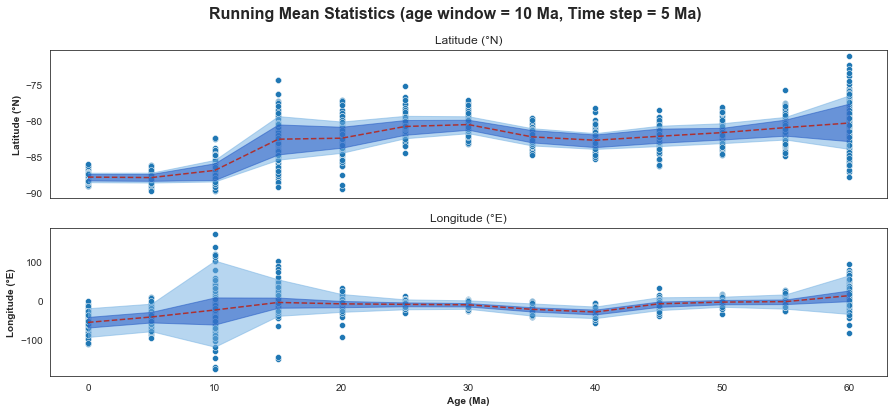

In [8]:
plot_APWP_RM_ensemble(RM_ensemble, f"Running Mean Statistics (age window = {window_length} Ma, Time step = {time_step} Ma)")

In [9]:
RM_ensemble_quant_plat = quantiles(RM_ensemble,"age","plat") # set quantiles of latitude groupedby age for visualization purposes
RM_ensemble_quant_plon = quantiles(RM_ensemble,"age","plon") # set quantiles of longitude groupedby age for visualization purposes

## Mean path

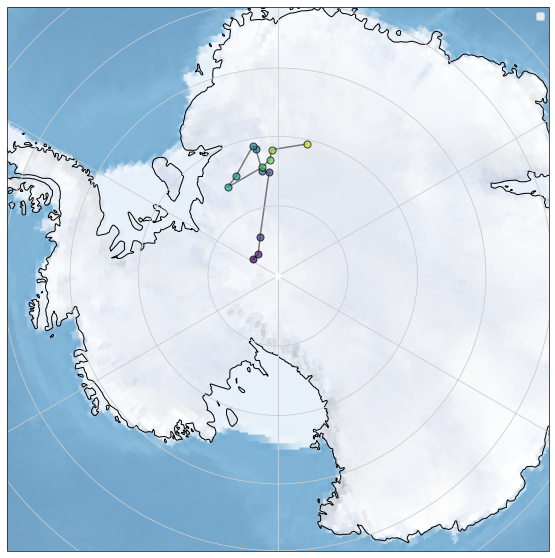

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic
from shapely.geometry import Polygon

extent = [-180,180,-70,-70]
fig = plt.figure(figsize=(20,10))

proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()
ax.set_extent(extent, crs = ccrs.PlateCarree())

# sns.scatterplot(x = RM_ensembl_quant_plon.mean, y =RM_ensemble_quant_plat.mean,
                
#                 transform = ccrs.PlateCarree())
plt.plot(RM_ensemble_quant_plon.mean, RM_ensemble_quant_plat.mean,transform = ccrs.Geodetic(), color = "black", alpha = 0.5)

for i in zip(RM_ensemble_quant_plat.mean, RM_ensemble_quant_plon.mean, RM_ensemble['age'].unique().transpose()):
    plot_pole(i[0],i[1],i[2],0,65,ax)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.show()